## LeNet-5 on MNIST (PyTorch)
- 经典结构: Conv(6)-AvgPool-Conv(16)-AvgPool-FC(120)-FC(84)-FC(10)
- 激活函数使用 Tanh，池化使用 AvgPool，输入从 28x28 通过 pad -> 32x32
- 几个 epoch 通常即可在 MNIST 上达到 98%+ 准确率

In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm

In [3]:
# ========== 随机种子 ==========
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

In [4]:
# ========== 配置 ==========
# 检测是否有GPU，若没有则使用cpu
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
                      else "cpu")
#设置batch size，epoch 用于优化器的学习率和momentum
batch_size = 128
epochs = 8
lr = 0.01
momentum = 0.9
num_workers = 2 if os.name != "nt" else 0  # Windows 下设 0 更稳

In [5]:
# ========== 数据集 ==========
# LeNet-5 期望输入 32x32，这里对 28x28 的 MNIST 在四周 pad 2 像素
# ToTensor：把 PIL 图像 / numpy 数组转换成 PyTorch 的张量，并自动把像素值从 [0, 255] 归一化到 [0, 1]
# Normalize：将其标准化，服从均值为 0，标准差为 1 的分布，从而加快收敛速度

transform = transforms.Compose([
    transforms.Pad(2),              # 28x28 -> 32x32
    transforms.ToTensor(),          # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 统计均值/方差
])

train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [6]:
# ========== 模型：LeNet-5 ==========
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # C1: 1x32x32 -> 6x28x28 (5x5 conv, no padding)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0, bias=True)
        # S2: AvgPool 6x28x28 -> 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: 6x14x14 -> 16x10x10
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=True)
        # S4: AvgPool 16x10x10 -> 16x5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: 16x5x5 -> 120x1x1  (经典 LeNet-5 的 conv 当作全连接)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0, bias=True)

        # F6: 120 -> 84
        self.fc1 = nn.Linear(120, 84)
        # OUTPUT: 84 -> 10
        self.fc2 = nn.Linear(84, num_classes)

        # 经典 LeNet 使用 Tanh
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.pool1(x)
        x = self.act(self.conv2(x))
        x = self.pool2(x)
        x = self.act(self.conv3(x))        # [B, 120, 1, 1]
        x = x.view(x.size(0), -1)          # [B, 120]
        x = self.act(self.fc1(x))          # [B, 84]
        x = self.fc2(x)                    # [B, 10]
        return x

In [7]:
model = LeNet5().to(device)
print(model)
# 参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params/1e6:.3f}M")

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (act): Tanh()
)
Total parameters: 0.062M


In [8]:
# ========== 优化器 & 损失 ==========
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)

# 可选：学习率衰减（余弦或 step）
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [9]:
# ========== 训练/评测函数 ==========
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        pbar.set_description(f"loss {running_loss/total:.4f} | acc {correct/total:.4f}")
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss_sum += loss.item() * imgs.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return loss_sum/total, correct/total

In [10]:
# ========== 训练循环 ==========
best_acc = 0.0
save_path = "lenet5_mnist.pt"
t0 = time.time()
for epoch in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    print(f"[Epoch {epoch:02d}] "
          f"train_loss={train_loss:.4f} train_acc={train_acc*100:.2f}% | "
          f"test_loss={val_loss:.4f} test_acc={val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "acc": best_acc,
                    "epoch": epoch}, save_path)

t1 = time.time()
print(f"Done. Best test acc: {best_acc*100:.2f}%. Time: {(t1-t0):.1f}s. Model saved to {save_path}")

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 01] train_loss=0.6120 train_acc=82.97% | test_loss=0.2167 test_acc=93.51%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 02] train_loss=0.1683 train_acc=95.07% | test_loss=0.1095 test_acc=96.98%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 03] train_loss=0.1002 train_acc=97.11% | test_loss=0.0786 test_acc=97.66%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 04] train_loss=0.0742 train_acc=97.81% | test_loss=0.0611 test_acc=98.01%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 05] train_loss=0.0617 train_acc=98.20% | test_loss=0.0518 test_acc=98.46%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 06] train_loss=0.0519 train_acc=98.51% | test_loss=0.0534 test_acc=98.39%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 07] train_loss=0.0487 train_acc=98.63% | test_loss=0.0455 test_acc=98.55%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 08] train_loss=0.0459 train_acc=98.71% | test_loss=0.0452 test_acc=98.65%
Done. Best test acc: 98.65%. Time: 112.6s. Model saved to lenet5_mnist.pt


In [11]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [12]:
# ========== 训练循环(绘制loss变化曲线) ==========
best_acc = 0.0
save_path = "lenet5_mnist.pt"
t0 = time.time()

train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()

    # === 记录 loss ===
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch:02d}] "
          f"train_loss={train_loss:.4f} train_acc={train_acc*100:.2f}% | "
          f"test_loss={val_loss:.4f} test_acc={val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "acc": best_acc,
                    "epoch": epoch}, save_path)

t1 = time.time()
print(f"Done. Best test acc: {best_acc*100:.2f}%. Time: {(t1-t0):.1f}s. Model saved to {save_path}")

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 01] train_loss=0.0437 train_acc=98.80% | test_loss=0.0436 test_acc=98.65%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 02] train_loss=0.0420 train_acc=98.83% | test_loss=0.0408 test_acc=98.69%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 03] train_loss=0.0388 train_acc=98.92% | test_loss=0.0387 test_acc=98.78%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 04] train_loss=0.0379 train_acc=98.98% | test_loss=0.0382 test_acc=98.82%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 05] train_loss=0.0372 train_acc=99.00% | test_loss=0.0378 test_acc=98.81%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 06] train_loss=0.0365 train_acc=99.02% | test_loss=0.0376 test_acc=98.79%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 07] train_loss=0.0357 train_acc=99.04% | test_loss=0.0375 test_acc=98.85%


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch 08] train_loss=0.0345 train_acc=99.08% | test_loss=0.0363 test_acc=98.87%
Done. Best test acc: 98.87%. Time: 105.0s. Model saved to lenet5_mnist.pt


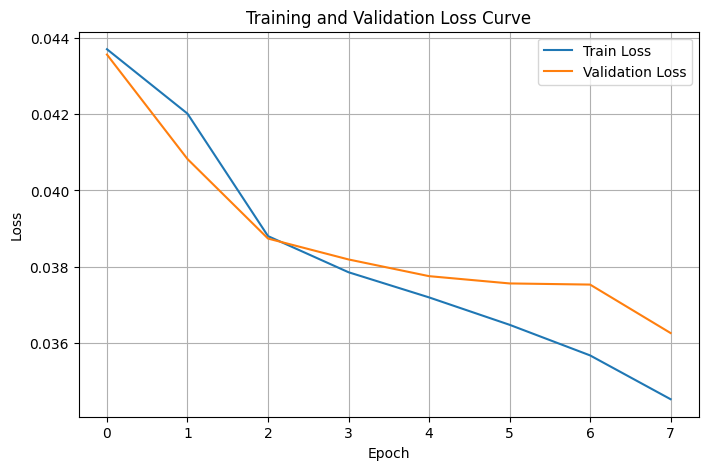

In [13]:
import matplotlib.pyplot as plt

# ========== 训练循环(绘制loss变化曲线) ==========
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import matplotlib.pyplot as plt

# ========== 载入与单样本推理 ==========
@torch.no_grad()
def quick_infer_sample():
    model.eval()
    img, label = test_set[514]         # 取一张测试图片
    x = img.unsqueeze(0).to(device)  # 增加 batch 维度
    logits = model(x)
    pred = logits.argmax(dim=1).item()

    # 打印预测结果
    print(f"GT label: {label}, Pred: {pred}")

    # 可视化图片
    plt.imshow(img.squeeze(0), cmap="gray") 
    plt.title(f"GT:{label}, Pred:{pred}")
    plt.axis("off")
    plt.show()

 

GT label: 6, Pred: 6


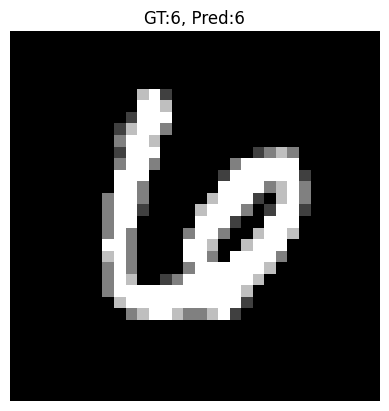

In [15]:
quick_infer_sample() 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# 反标准化，用于把 MNIST 张量还原成可显示的灰度图
mean, std = 0.1307, 0.3081

def denormalize(img_tensor):
    """
    img_tensor: [1, 32, 32] 的单通道图像
    返回 numpy [H, W]，范围约在 [0,1]
    """
    img = img_tensor.clone().cpu()
    img = img * std + mean
    img = img.squeeze(0).numpy()
    img = np.clip(img, 0, 1)
    return img

def show_side_by_side(img_left, img_right, title_left="", title_right="", cmap_left="gray", cmap_right="jet"):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_left, cmap=cmap_left)
    plt.title(title_left)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_right, cmap=cmap_right)
    plt.title(title_right)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

直接用现有的 conv1、pool1、conv2，对某个测试样本算出 conv2 的特征图，然后在通道维度上求平均，作为“注意力图”。

In [17]:
# 1. 注册 hook，抓取 conv2 的 feature map 和梯度
target_layer = model.conv2

feature_maps = None
gradients = None

def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    # grad_output 是一个 tuple，这里取对输出的梯度
    gradients = grad_output[0]

# 注册 hook（只需执行一次）
handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)


def generate_gradcam(x, class_idx=None):
    """
    x: [1, 1, 32, 32]
    返回: cam_up [32, 32] numpy
    """
    global feature_maps, gradients
    feature_maps = None
    gradients = None

    model.eval()
    logits = model(x)                 # 前向，激活 forward hook

    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    score = logits[:, class_idx]
    model.zero_grad()
    score.backward(retain_graph=True) # 反向，激活 backward hook

    # feature_maps: [1, C, H, W]  例如 [1, 16, 10, 10]
    # gradients:    [1, C, H, W]
    grads = gradients
    fmap = feature_maps

    # 对梯度在空间维度求平均，得到每个通道的权重 alpha_k
    weights = grads.mean(dim=(2, 3), keepdim=True)   # [1, C, 1, 1]

    # 加权求和得到 Grad-CAM
    cam = (weights * fmap).sum(dim=1, keepdim=True)  # [1, 1, H, W]
    cam = F.relu(cam)
    cam = cam.squeeze().detach().cpu().numpy()
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    # 插值到 32x32 方便与原图对齐
    cam_up = F.interpolate(
        torch.tensor(cam)[None, None, ...],
        size=(32, 32),
        mode="bilinear",
        align_corners=False
    ).squeeze().numpy()

    return cam_up

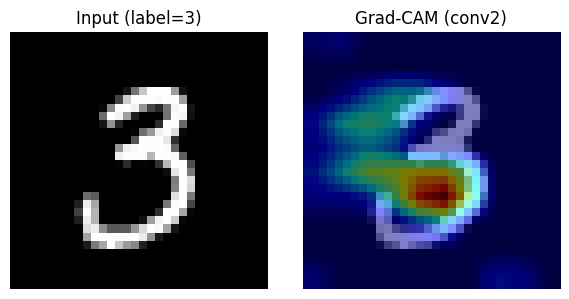

In [29]:
def gradcam_example(idx=514):
    img, label = test_set[idx]           # [1, 32, 32]
    x = img.unsqueeze(0).to(device)      # [1, 1, 32, 32]

    cam_up = generate_gradcam(x)

    img_np = denormalize(img)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img_np, cmap="gray")
    plt.title(f"Input (label={label})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(img_np, cmap="gray")
    plt.imshow(cam_up, cmap="jet", alpha=0.5)
    plt.title("Grad-CAM (conv2)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 运行一个示例
gradcam_example(idx=90)